# Scoring and alignment

`shepherd_score` provides both base functions and convenience classes to facilitate scoring and alignment.

We have noticed a bug where the torch.cdist function stalls with point clouds >50 on cpu Mac OS but have not had this issue on linux, so beware. There are no issues with numpy or jax.

## Convenience classes

First, we show how to use convenience wrappers for scoring and alignment. Let's import useful constants, methods to generate conformers, and abstracted wrappers useful for extracting profiles and scoring them.

In [1]:
import open3d # open3d can occasionally cause issues during imports; importing it first can help alleviate that
from rdkit import Chem
from shepherd_score.score.constants import ALPHA, LAM_SCALING
from shepherd_score.conformer_generation import embed_conformer_from_smiles
from shepherd_score.conformer_generation import optimize_conformer_with_xtb
from shepherd_score.container import Molecule, MoleculePair

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


First, let's generate some (random) conformers of two molecules. The smaller of the two has a similar substructure to the other. We use xTB to relax the conformers initially generated by RDKit (and MMFF94 optimized) which also gives us the partial charges.

In [2]:
# Embed a random conformer with RDKit
ref_mol_rdkit = embed_conformer_from_smiles('c1Cc2ccc(Cl)cc2C(=O)c1c3cc(N1nnc2cc(C)c(Cl)cc2c1=O)ccc3', MMFF_optimize=True)
fit_mol_rdkit = embed_conformer_from_smiles('N1nnc2ccc(Cl)cc2c1=O', MMFF_optimize=True)
# Local relaxation with xTB
ref_mol, _, ref_charges = optimize_conformer_with_xtb(ref_mol_rdkit)
fit_mol, _, fit_charges = optimize_conformer_with_xtb(fit_mol_rdkit)

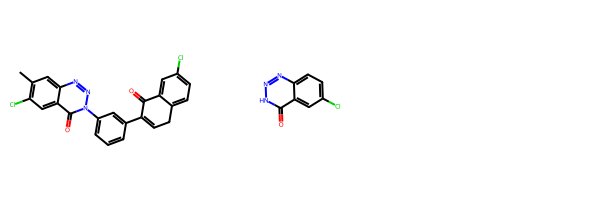

In [3]:
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in ['c1Cc2ccc(Cl)cc2C(=O)c1c3cc(N1nnc2cc(C)c(Cl)cc2c1=O)ccc3',
                                                               'N1nnc2ccc(Cl)cc2c1=O']])

### `Molecule`

`Molecule` objects automatically extract interaction profiles. Here, we specify the number of surface points, which partial charges to use to get the electrostatic potential at each of the sampled surface points, and use a representation of pharmacophores that averages directional representations of the same type (`pharm_multi_vector=False`).

In [4]:
# Extract interaction profiles
# Generates a surface with 200 sampled points
#  attributed with ESP using the xTB partial charges
#  and extracts pharmacophores with averaged vectors
ref_molec = Molecule(ref_mol,
                     num_surf_points=200,
                     partial_charges=ref_charges,
                     pharm_multi_vector=False)
fit_molec = Molecule(fit_mol,
                     num_surf_points=200,
                     partial_charges=fit_charges,
                     pharm_multi_vector=False)

### `MoleculePair`

The `MoleculePair` class facilitates easy scoring between two conformations as well as alignment. Note that by setting `do_center=True` we align each molecule's center of mass to the origin which would not be desirable if we wanted to do a local relaxation.

In [5]:
# Centers the two molecules' COM's to the origin
mp = MoleculePair(ref_molec, fit_molec, num_surf_points=200, do_center=True)

#### Scoring

In [6]:
# Score with your preferred objective function
# By default we use numpy
shape_score = mp.score_with_surf(ALPHA(mp.num_surf_points))
esp_score = mp.score_with_esp(ALPHA(mp.num_surf_points), lam=0.3)
pharm_score = mp.score_with_pharm()

In [7]:
shape_score, esp_score, pharm_score

(0.23719206159987358, 0.23599669518162456, 0.02791562161843163)

#### Global Alignment
Global alignment assumes that we don't care about the initial alignment as we want to try to find the global minima. We previously aligned the COM's at the origin during the initialization of `MoleculePair`. The alignment methods, `.align_with_*`, all take the argument `num_repeats` which is the number of different initial alignments to optimize over. When `num_repeats > 1`, there are 3 main types of initializations: 

1. The first initialization maintains the rotational orientations of both molecules, but aligns the fit molecule's COM is moved to the reference molecule's COM.
2. The next four initializations align the molecules by their principal components.
3. If `num_repeats > 5`, the remaining initializations are uniformly spaced rotations of the fit molecule.

The default `num_repeats=50`. Examples are shown below:

In [8]:
# Align fit_molec to ref_molec with your preferred objective function
# By default we use automatic differentiation via pytorch
surf_points_aligned = mp.align_with_surf(ALPHA(mp.num_surf_points),
                                         num_repeats=50)
surf_points_esp_aligned = mp.align_with_esp(ALPHA(mp.num_surf_points),
                                            lam=0.3,
                                            num_repeats=50)
pharm_pos_aligned, pharm_vec_aligned = mp.align_with_pharm(num_repeats=50)

In [9]:
# Optimal scores are stored as attributes
mp.sim_aligned_surf, mp.sim_aligned_esp, mp.sim_aligned_pharm

(array(0.41102654, dtype=float32),
 array(0.40883726, dtype=float32),
 array(0.4328944, dtype=float32))

In [10]:
# Optimal SE(3) transformation matrices are stored as attributes
mp.transform_surf, mp.transform_esp, mp.transform_pharm

(array([[ 0.78816795, -0.5605407 ,  0.25413665,  4.9925504 ],
        [ 0.5984361 ,  0.601534  , -0.52917963,  0.91717577],
        [ 0.14375487,  0.56916696,  0.80955756,  0.6054885 ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],
       dtype=float32),
 array([[ 0.78851587, -0.56040245,  0.253361  ,  5.0015197 ],
        [ 0.5979896 ,  0.6023489 , -0.5287572 ,  0.9237334 ],
        [ 0.1437051 ,  0.5684407 ,  0.8100766 ,  0.60548335],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],
       dtype=float32),
 array([[-0.8010564 ,  0.33625808,  0.49521634,  4.157612  ],
        [-0.5743425 , -0.19869089, -0.79413635,  0.25773704],
        [-0.16863981, -0.92057174,  0.35228997,  0.31910408],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],
       dtype=float32))

In [11]:
# Get a copy of the optimally aligned fit Molecule object
transformed_fit_molec = mp.get_transformed_molecule(
    se3_transform=mp.transform_surf
)

##### Global alignment with translation initializations
The above code is generally sufficient for aligning molecules of the same relative size. However, sometimes we may want to be more thorough about the global search and/or we may be aligning a smaller molecule to a larger one. In the latter case, starting with aligned COM's may be insufficient for finding the best possible alignment.

Therefore, each alignment method also contains an argument called `trans_init`. If set to `True`, the COM of the fit molecule will be shifted to each heavy atom of the reference molecule (in addition to principal component alignment). 10 uniform rotations are then sampled leading to `(5 + 10*num_ref_heavy_atoms)` different initializations.

In [ ]:
surf_points_aligned_trans = mp.align_with_surf(ALPHA(mp.num_surf_points),
                                               num_repeats=50,
                                               trans_init=True)

#### Local Alignment

In some cases, only local optimization is necessary. For example, if you have two overlayed molecules and you want to refine the alignment. To do so there are two important points:
1. Initialize `MoleculePair` with `do_center=False` so that the supplied conformers are not automatically aligned by their COM's.
2. Ensure that `mp.align_*(num_repeats=1)` so that the optimization procedure is initialized for the original alignment.

In [ ]:
mp = MoleculePair(ref_molec, fit_molec, num_surf_points=200, do_center=False)
surf_points_aligned_trans = mp.align_with_surf(ALPHA(mp.num_surf_points),
                                               num_repeats=1)

#### Additional notes
- If your molecular system is not near the origin, it is possible that the default step size or learning rate (default `lr=0.1`) is too large and can lead to catostrophic optimization updates. The reason for this is that the updates to rotation matrices are applied with respect to the global frame rather than a local one. To solve this, you can either:
    1. Reduce the learning rate.
    2. Center your entire (combined) system to the origin.

## Raw scoring functions

The modules `gaussian_overlap`, `electrostatic_scoring`, and `pharmacophore_scoring` contain the PyTorch versions of the scoring functions `get_overlap`, `get_overlap_esp`, and `get_overlap_pharm`, respectively. Appending `*_np` or `*_jax` has the NumPy versions and Jax versions, respectively.

In [ ]:
from shepherd_score.score.constants import ALPHA
from shepherd_score.score.gaussian_overlap_np import get_overlap_np
from shepherd_score.score.electrostatic_scoring_np import get_overlap_esp_np
from shepherd_score.score.pharmacophore_scoring_np import get_overlap_pharm_np

In [13]:
# Shape scoring
# Volumetric use alpha=0.81
vol_overlap = get_overlap_np(centers_1=ref_molec.atom_pos,
                             centers_2=fit_molec.atom_pos,
                             alpha=0.81)

# For surface use ALPHA(num_surf_points) where 150 < num_surf_points < 400
surf_overlap = get_overlap_np(centers_1=ref_molec.surf_pos,
                              centers_2=fit_molec.surf_pos,
                              alpha=ALPHA(200))
vol_overlap, surf_overlap

(0.2429967763390559, 0.23719206159987358)

In [14]:
# ESP scoring -> must scale `lam` by LAM_SCALING
#  We fit lam=0.3*LAM_SCALING
surf_esp_overlap = get_overlap_esp_np(centers_1=ref_molec.surf_pos,
                                      centers_2=fit_molec.surf_pos,
                                      charges_1=ref_molec.surf_esp,
                                      charges_2=fit_molec.surf_esp,
                                      alpha=ALPHA(200),
                                      lam=0.3*LAM_SCALING)
surf_esp_overlap

0.23599669518162456

In [15]:
# Pharmacophore scoring
pharm_overlap = get_overlap_pharm_np(ptype_1=ref_molec.pharm_types,
                                     ptype_2=fit_molec.pharm_types,
                                     anchors_1=ref_molec.pharm_ancs,
                                     anchors_2=fit_molec.pharm_ancs,
                                     vectors_1=ref_molec.pharm_vecs,
                                     vectors_2=fit_molec.pharm_vecs,
                                     similarity='tanimoto',
                                     extended_points=False,
                                     only_extended=False)
pharm_overlap

0.02791562161843163